<a href="https://colab.research.google.com/github/EsamSharaf/DS-ML-Forecasting-Sales/blob/main/Walmart_Sales_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Intro**

**The dataset is related to 45 stores where each store comprises 98-99 departments. The dataset provides the Weekly Sales between 05-02-2010 to 01.11.2012 per Department/Store. The aim of this task is to forecast future Weekly Sales per Department in a given Store based on the historical data. The data records provided with the following features:**

**1. Store: numbered from 1-45 (Discrete).**

**2. Department number (Discrete).**

**3. Date: 05-02-2010 to 01.11 as weekly data.**).

**4. Weekly Sales: for each department/Store (Continuous).**

**5. Temperature: average temperature in the region (Continuous).**

**6. Fuel_Price: Cost of fuel in the region (Continuous).**

**7. CPI: the consumer price index (Continuous).**

**8. Unemployment: the unemployment rate (Continuous).**

**9. Type: Type of the store (Categorical).**

**10. Size: Size of the store (Continuous).**

**11. IsHoliday: whether the week has a special holiday (Bolean).**

**12. MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time (Continuous).**

**This task represents univariate time series forecast - the Weekly Sales- with exogenous factors/variables.**

**Where Holiday is True, it is expected to have spike in Sales. Otherwise, it is expected to deal with normal range of sales around the mean of annual sales that is for an arbitrary store. For that reason, Weighted Absolute Mean Error(WAME) used where Holidy Weeks weighted 5 times.**

**2011 is the only year with full Weekly Sales Cycle (52 records). 2010's records starts at 05.02.2010. This is expected to have little effect on this period's future predictions since there is no holidays before it. Thus, the values close to the mean of Weekly Sales.**

**2012's records until 26.10.2012. This makes the historic data not ideal for making future predictions.**

**Adding Week Number to the variables set will help to capture the holiday seasons.**



In [ ]:
import gc   #garbage collector interface
#triggering collection
gc.collect()

11015

In [ ]:
print("Garbage collection thresholds:", gc.get_threshold())

Garbage collection thresholds: (700, 10, 10)


In [ ]:
# instal pmdarima
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import TransformedTargetRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [ ]:
import pmdarima as pm

In [ ]:
from pmdarima import arima
from pmdarima import pipeline
from pmdarima import preprocessing as ppc
from pmdarima import arima

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Helper Functions**

In [ ]:
# Performance metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae,
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 'corr':corr, 'minmax':minmax})


In [ ]:
# Loss Function (Weighted Mean Absolute Error)
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 4)

##**Exploratory Data Analysis and Data Cleaning**

In [ ]:
features = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/walmart-store-dataset/features.csv')
train = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/walmart-store-dataset/train.csv')
stores = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/walmart-store-dataset/stores.csv')
test = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/walmart-store-dataset/test.csv')

In [ ]:
feature_store_df = features.merge(stores, how='inner', on='Store')

In [ ]:
feature_store_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [ ]:
df = train.merge(feature_store_df, how='inner', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)

In [ ]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [ ]:
# Check the data types
pd.DataFrame(df.dtypes, columns=['Data Type'])

,Data Type
Store,int64
Dept,int64
Date,object
Weekly_Sales,float64
IsHoliday,bool
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64


In [ ]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


**Features are in different scales, therefore data transformation will be applied through Pipelines**

In [ ]:
# Check null values in the training set
null_data_count = df.isnull().sum(axis = 0)
null_data_percent = (df.isnull().sum(axis=0)/len(df)) *100
null_data = (pd.concat([null_data_count, null_data_percent], axis=1))
null_data = null_data.rename(columns={0: "# Null", 1:"% Null"})
null_data = null_data[null_data["# Null"]!=0].sort_values(ascending=False, by="% Null")
null_data

,# Null,% Null
MarkDown2,310322,73.611025
MarkDown4,286603,67.984676
MarkDown3,284479,67.480845
MarkDown1,270889,64.257181
MarkDown5,270138,64.079038


In [ ]:
# Impute NAN values by 0
null_data_index= null_data.index.values.tolist()
print(null_data_index)
for col in null_data_index:
  df[col].fillna(0, inplace = True)

['MarkDown2', 'MarkDown4', 'MarkDown3', 'MarkDown1', 'MarkDown5']


In [ ]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [ ]:
# Derive Week and Year Columns from Date Column. This helps in capturing Seasonality
df.Date = pd.to_datetime(df.Date)
df['Week'] = df.Date.dt.isocalendar().week
df['Year'] = df.Date.dt.year

In [ ]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,39,2012
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221,41,2012
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221,42,2012


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


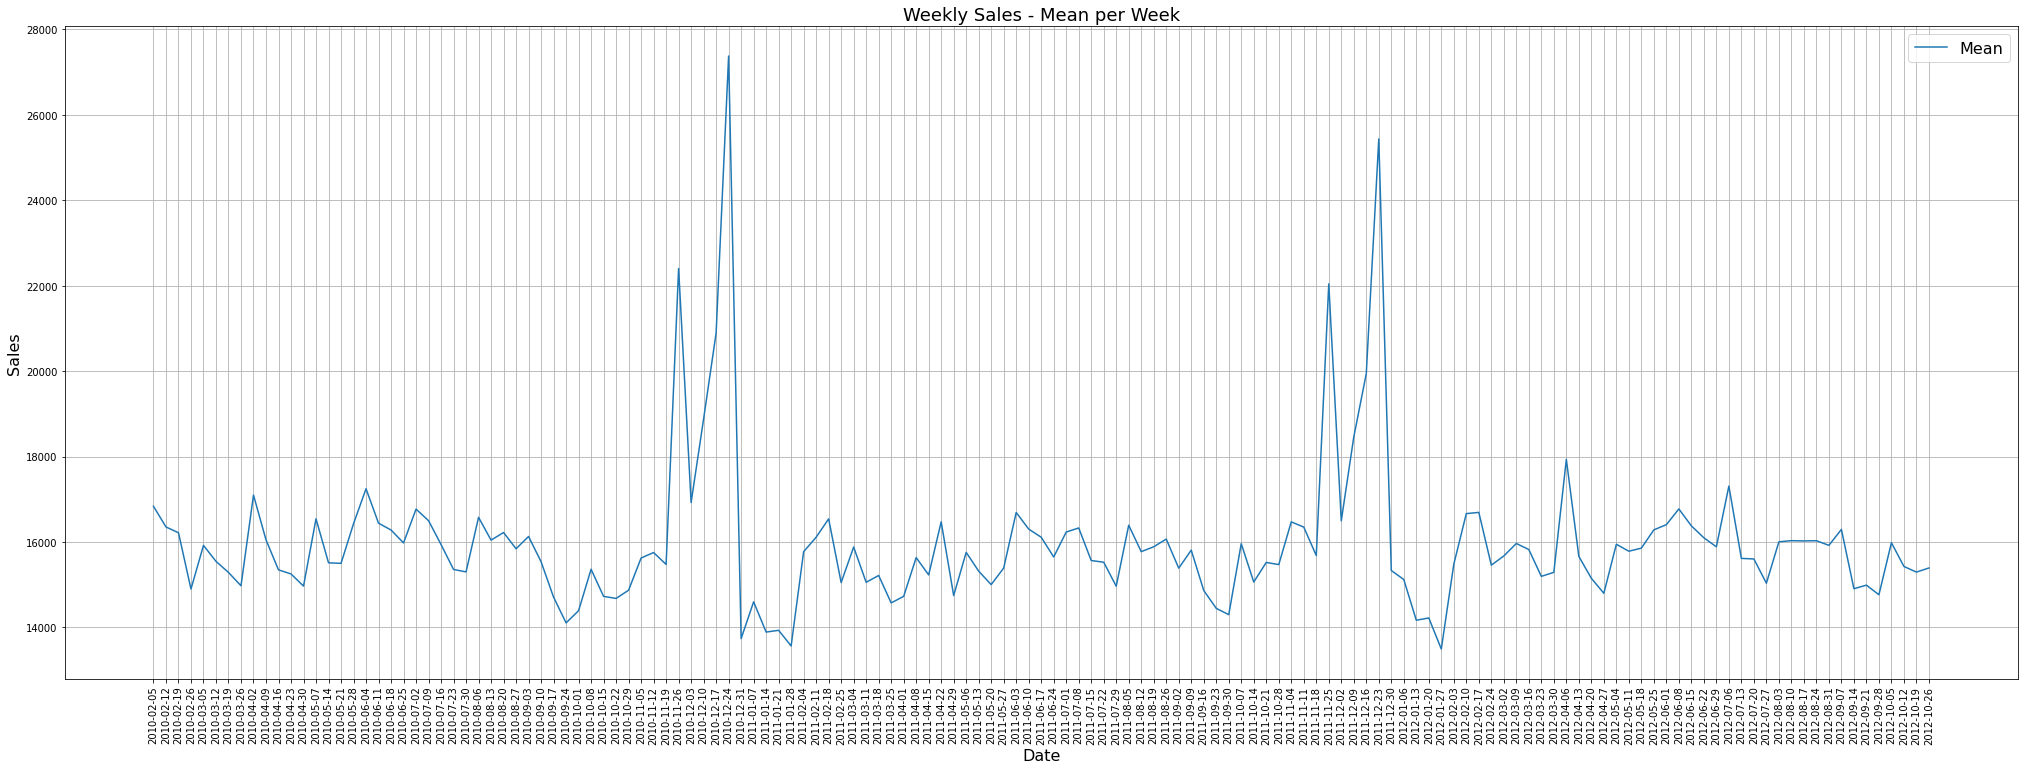

In [ ]:
# Plot average Weekly Sales by Date
weekly_sales_by_date= df['Weekly_Sales'].groupby(df['Date']).mean()
plt.figure(figsize=(35,12))
sns.lineplot(weekly_sales_by_date.index, weekly_sales_by_date.values)
plt.grid()
plt.legend(['Mean'], loc='best', fontsize=16)
plt.title('Weekly Sales - Mean per Week', fontsize=18)
plt.xticks(weekly_sales_by_date.index, rotation=90)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

**The time-series exhibits seasonality at Holiday Weeks (each 52 Weeks Cycle). Plotting mean Weekly Sales shows that that there are seasons at Holiday Weeks like Christmas -in December-, Thanksgiven -in Nov.- in forms of peaks in Sales. This makes the timer-series nonstationary.**

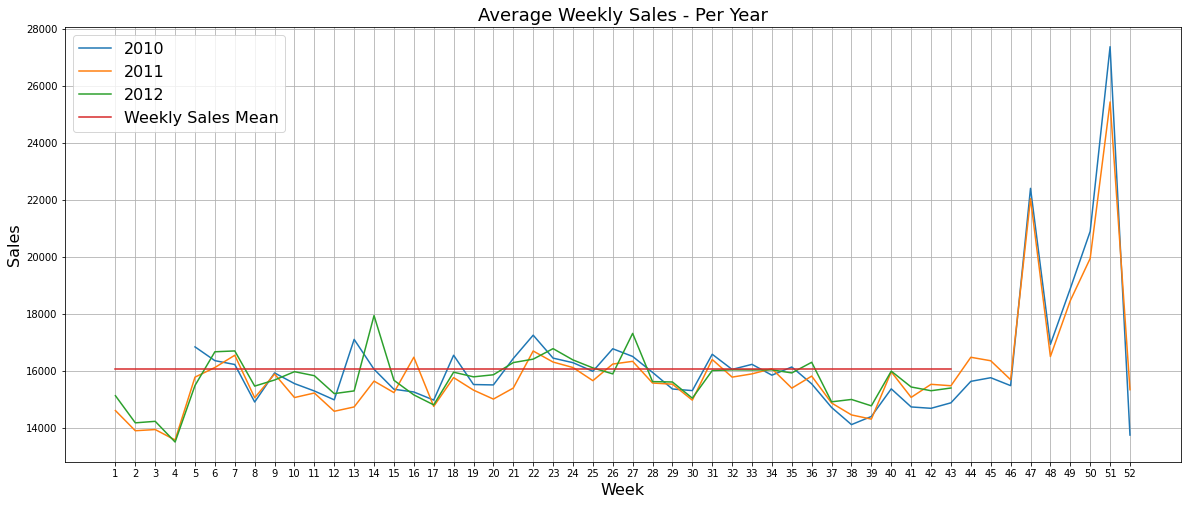

In [ ]:
# Plot Average Weekly Sales for years 2010, 2011 and 2012
weekly_sales_2010 = (df[df.Year==2010].groupby(['Week'])['Weekly_Sales']).mean()
weekly_sales_2011 = (df[df.Year==2011].groupby(['Week'])['Weekly_Sales']).mean()
weekly_sales_2012 = (df[df.Year==2012].groupby(['Week'])['Weekly_Sales']).mean()
weekly_sales_mean = df['Weekly_Sales'].groupby(df['Week']).mean().mean() #the mean across Weekly_Sales series
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_mean)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012', 'Weekly Sales Mean'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


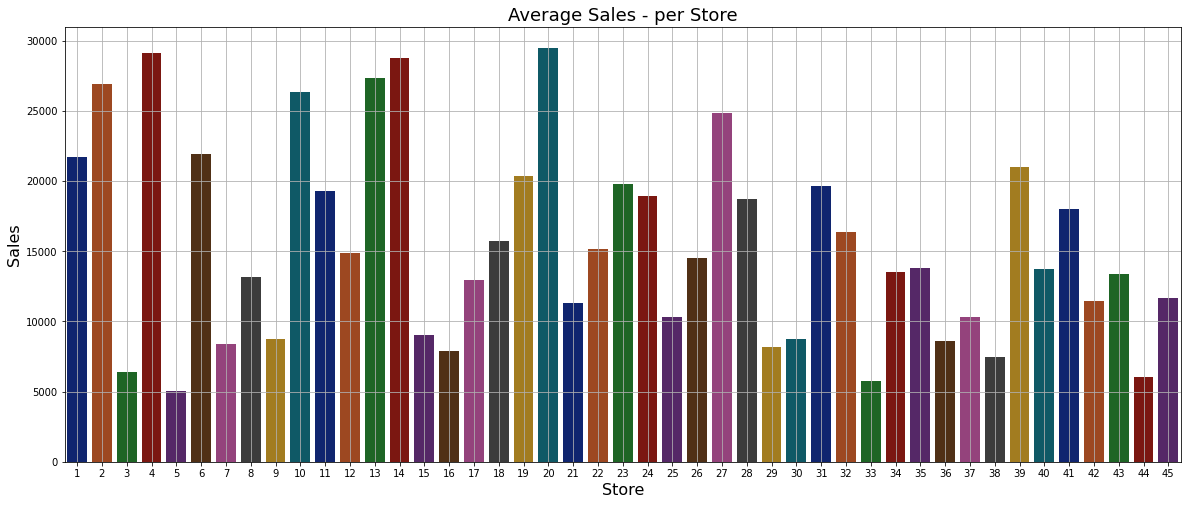

In [ ]:
# Plot Average Weekly Sales "per Store" across 2010, 2011 and 2012
weekly_sales_per_Store = df['Weekly_Sales'].groupby(df['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales_per_Store.index, weekly_sales_per_Store.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

**Sales are different from store to another.**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


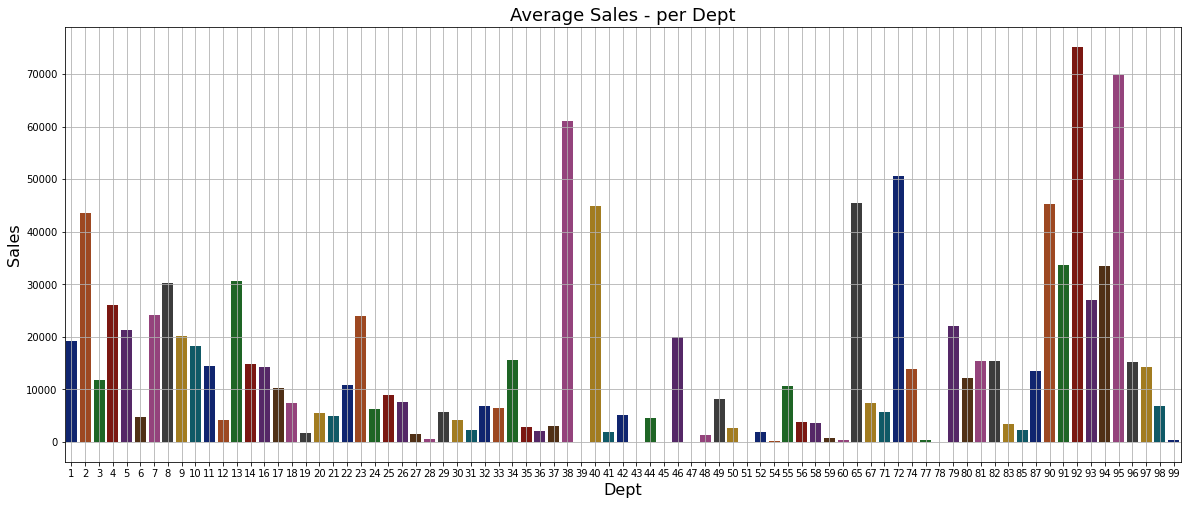

In [ ]:
# Plot Average Weekly Sales "per Department" across 2010, 2011 and 2012
weekly_sales_per_dep = df['Weekly_Sales'].groupby(df['Dept']).mean()
plt.figure(figsize=(20,8))
sns.barplot(weekly_sales_per_dep.index, weekly_sales_per_dep.values, palette='dark')
plt.grid()
plt.title('Average Sales - per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

**Departments have different sales as well**

**Weekly Sales of Small Store vs Weekly Sales of Big Store**

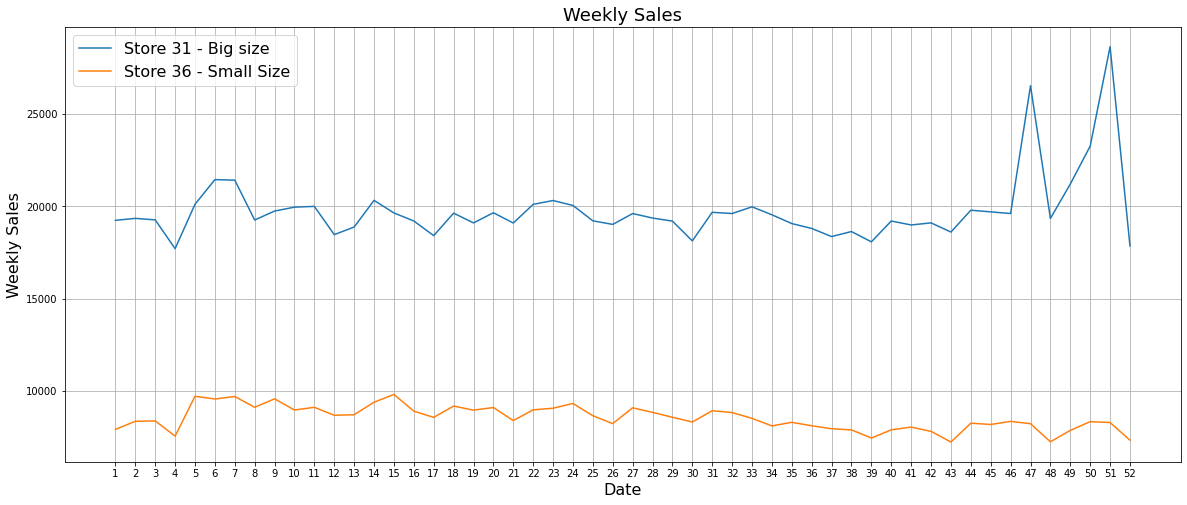

In [ ]:
weekly_sales_store35 = df[df.Store==31].groupby(["Week"])["Weekly_Sales"].mean()
weekly_sales_store36 = df[df.Store==36].groupby(["Week"])["Weekly_Sales"].mean()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_store35.index, y=weekly_sales_store35)
sns.lineplot(x=weekly_sales_store36.index, y=weekly_sales_store36)
#sns.lineplot(x=weekly_sales_store3.index, y=weekly_sales_store3)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['Store 31 - Big size', 'Store 36 - Small Size'] , loc='best', fontsize=16)
plt.title('Weekly Sales', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

**As shown big difference in Sales pattern between small and big-sized stores. For example, Store 31 (Big in size) shows Seasonality while Store 31 (Small) does not. Designing models specific for each store would be better.**

**Visualizing Two Departments' Sales of one store**

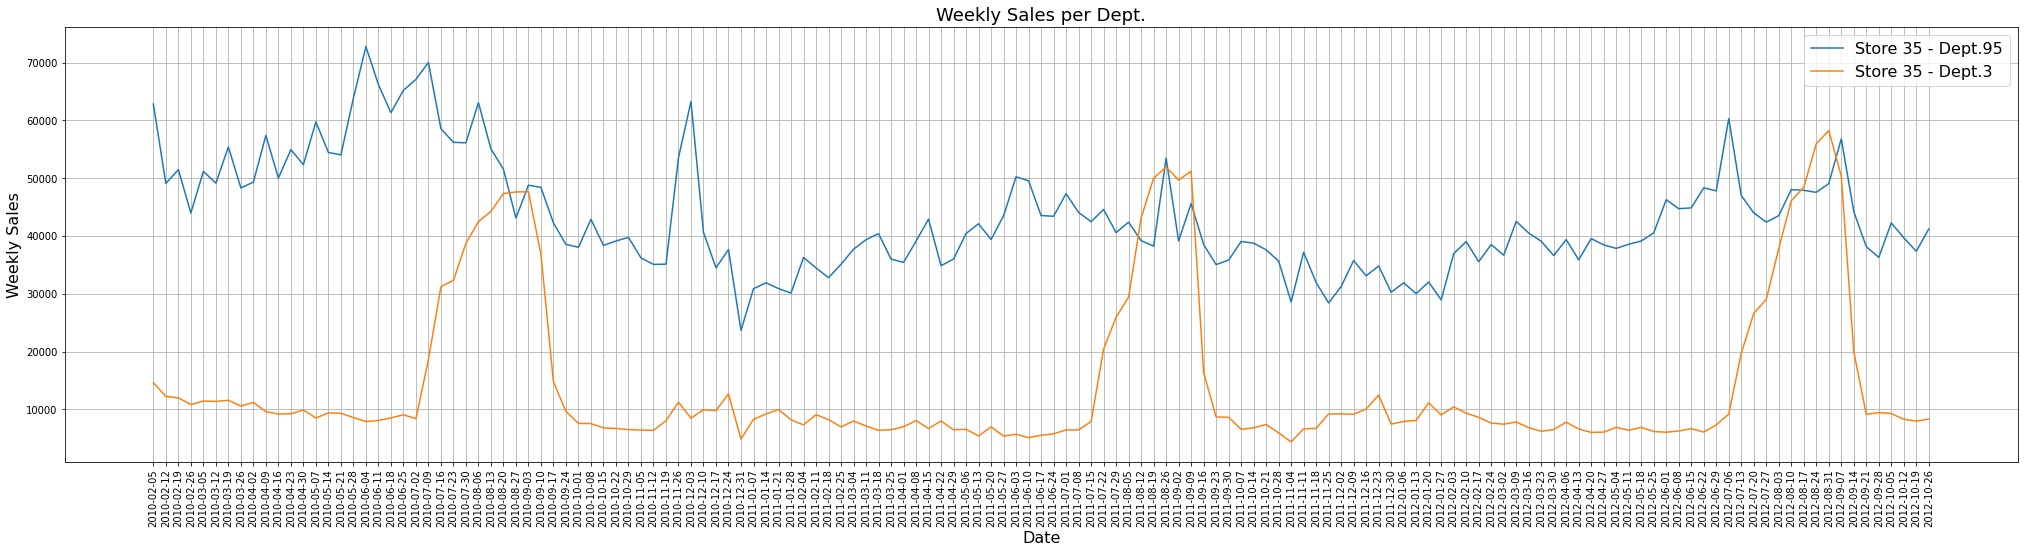

In [ ]:
weekly_sales_store35_dept95 = df.loc[(df.Store==35) & (df.Dept==95)]["Weekly_Sales"]
weekly_sales_store35_dept3 = df.loc[(df.Store==35) & (df.Dept==3)]["Weekly_Sales"]
indx = df.loc[(df.Store==35) & (df.Dept==95)].Date
indx2 = df.loc[(df.Store==35) & (df.Dept==3)].Date
plt.figure(figsize=(35,8))
sns.lineplot(x=indx, y=weekly_sales_store35_dept95)
sns.lineplot(x=indx2, y=weekly_sales_store35_dept3)
plt.grid()
plt.xticks(indx, rotation = 90)
plt.legend(['Store 35 - Dept.95', 'Store 35 - Dept.3'], loc='best', fontsize=16)
plt.title('Weekly Sales per Dept.', fontsize=18)
plt.ylabel('Weekly Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

**Sales Patterns are different within the same store. For example, the above plot portrays the sales of dept. 95 and dept. 3. The demand on on dept 95's is high across the year, wheres dept 3 seems like has a demand on summer months where high peaks occur in cycles.**

**Plotting the Histogram of "Weekly Sales" (The target variable)**

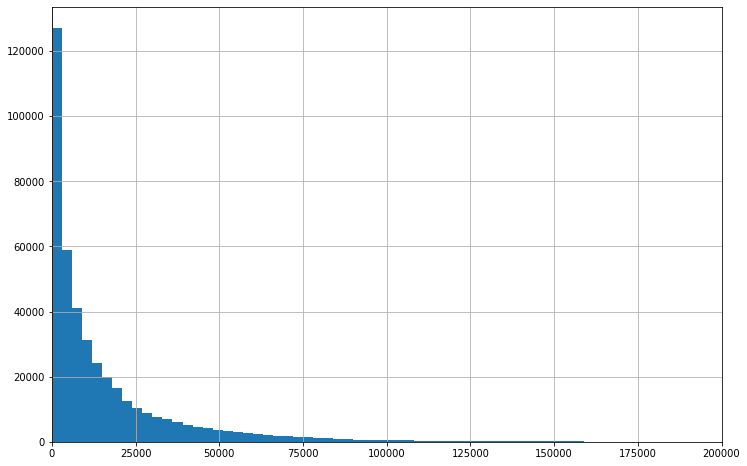

In [ ]:
fig = plt.figure(figsize=(12,8))
n, bins, patches = plt.hist(df.Weekly_Sales, bins=[i for i in range (0, 200000, 3000)])
plt.xlim(0, 200000)
plt.grid(True)
plt.show()

**Weekly_Sales is right skewed**

**Apply Power Transformer to make the data Normally Distributed**

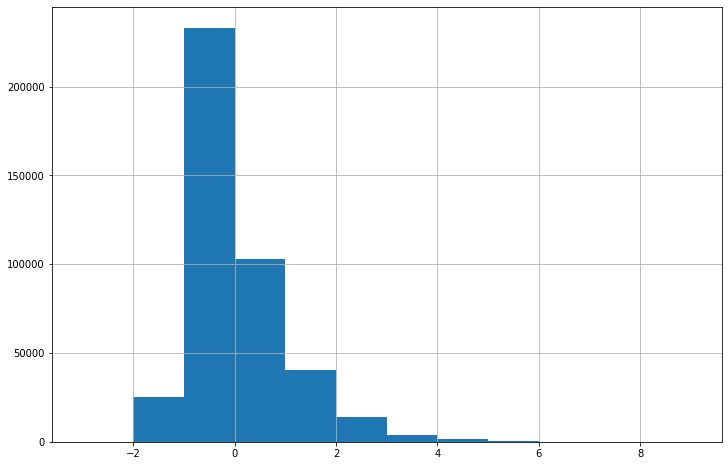

In [ ]:
from sklearn.preprocessing import PowerTransformer
fig = plt.figure(figsize=(12,8))
pt = PowerTransformer()
power_transformed_series = pt.fit_transform(np.array(df.Weekly_Sales).reshape(-1,1))
n, bins, patches = plt.hist(power_transformed_series, bins=[i for i in range (-3, 10)])
plt.grid(True)
plt.show()

**Plotting Scatter plots for continuous variables with Weekly_Sales**

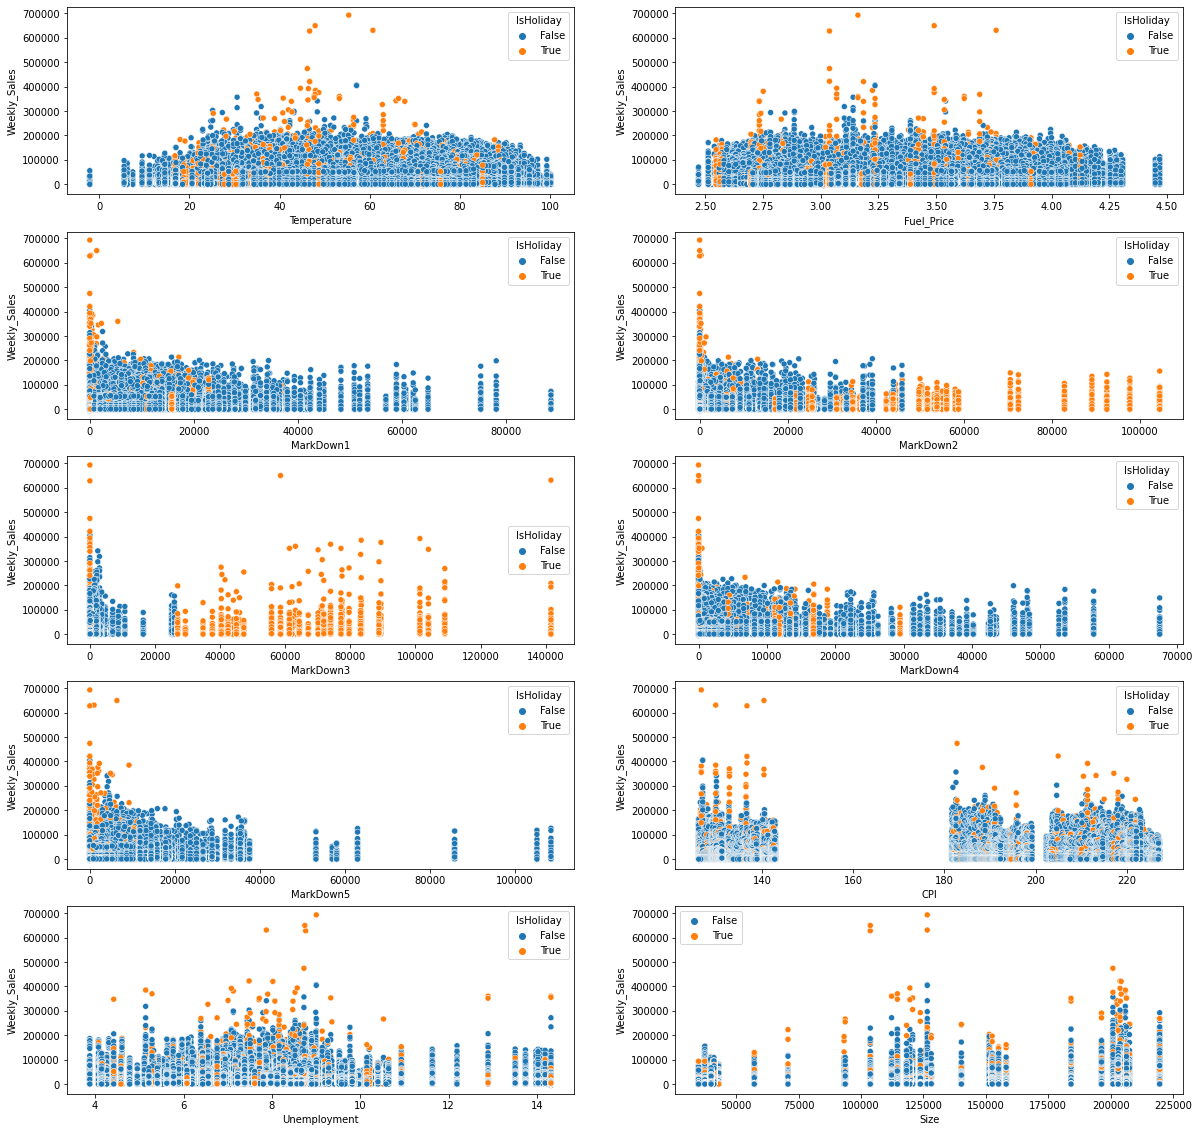

In [ ]:
fig,axes= plt.subplots(5,2, figsize=(20,20))
sns.scatterplot(data=df, x='Temperature', y='Weekly_Sales', ax=axes[0,0], hue='IsHoliday')
sns.scatterplot(data=df, x='Fuel_Price', y='Weekly_Sales', ax=axes[0,1], hue='IsHoliday')
sns.scatterplot(data=df, x='MarkDown1', y='Weekly_Sales', ax=axes[1,0], hue='IsHoliday')
sns.scatterplot(data=df, x='MarkDown2', y='Weekly_Sales', ax=axes[1,1], hue='IsHoliday')
sns.scatterplot(data=df, x='MarkDown3', y='Weekly_Sales', ax=axes[2,0], hue='IsHoliday')
sns.scatterplot(data=df, x='MarkDown4', y='Weekly_Sales', ax=axes[2,1], hue='IsHoliday')
sns.scatterplot(data=df, x='MarkDown5', y='Weekly_Sales', ax=axes[3,0], hue='IsHoliday')
sns.scatterplot(data=df, x='CPI', y='Weekly_Sales', ax=axes[3,1], hue='IsHoliday')
sns.scatterplot(data=df, x='Unemployment', y='Weekly_Sales', ax=axes[4,0], hue='IsHoliday')
sns.scatterplot(data=df, x='Size', y='Weekly_Sales', ax=axes[4,1], hue='IsHoliday')
plt.legend(loc='upper left')

**It is shown that the bigger stores's size the higher weekly sales, the rest have no obvious pattern with Weekly Sales**

**Plotting Box Plot for Categorical (Type, IsHoliday) variables with Weekly_Sales**

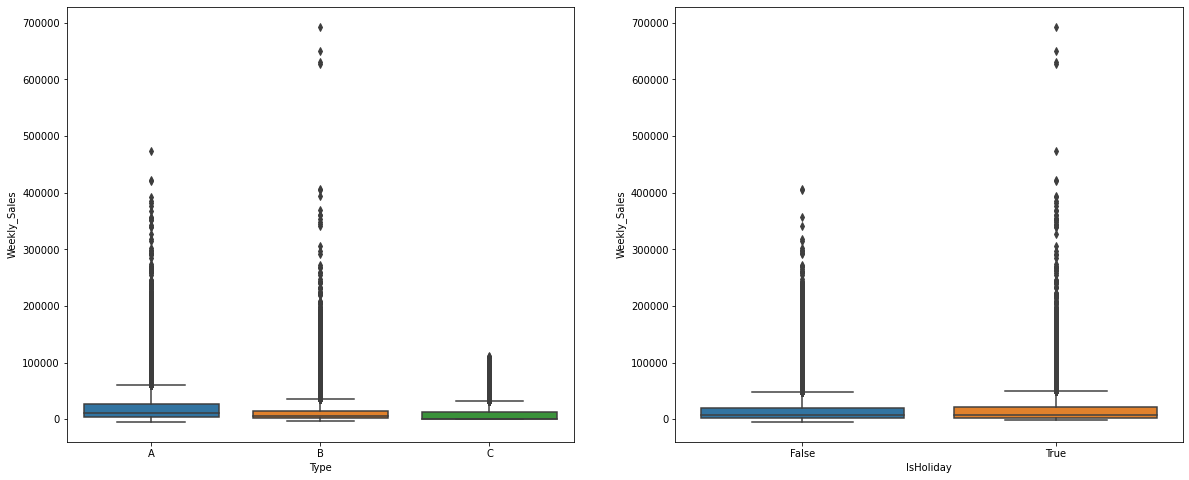

In [ ]:
fig,axes= plt.subplots(1,2, figsize=(20,8))
sns.boxplot(data=df, x='Type', y='Weekly_Sales', ax=axes[0])
sns.boxplot(data=df, x='IsHoliday', y='Weekly_Sales', ax=axes[1])

**Type of the store (A,B,C) has a relation with sales(median A > median B > median C)**

**The median in Holiday Weeks is higher in value than normal weeks**

In [ ]:
# Make Date as Index of df
df.set_index("Date", inplace = True, drop=True)

**Plotting linear Correlations**

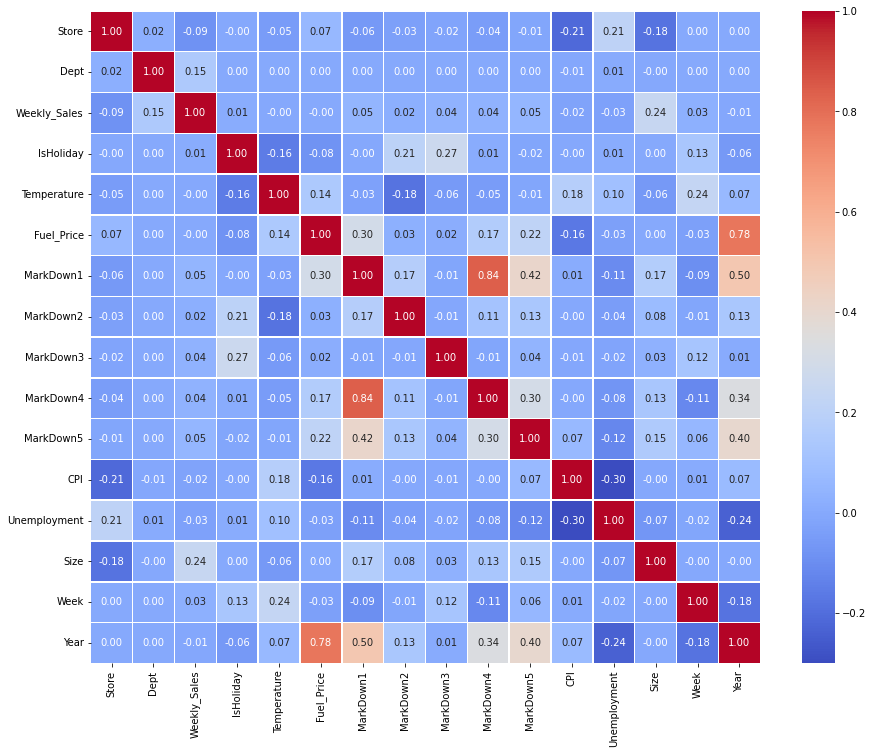

In [ ]:
# Calculate Pearson's Correlation to capture linear relationships w/ Weekly Sales
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(method ='pearson'),annot=True,linewidth=0.5,fmt="0.2f", cmap = 'coolwarm')
plt.show()

**The heatmap shows that Weekly Sales has week "linear" correlation with Size and Department variables, wheres it is around zero with the rest.**
**Fuel price and Year hold high colinearity. It is better to drop one of them.**
**Markdown 1-5 variables are anonymized plus having week relationship with Weekly Sales. So it is is reasonable to drop them.**

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


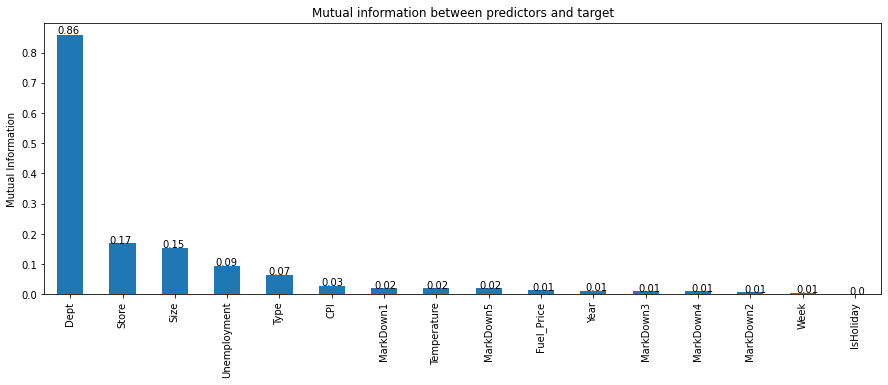

In [ ]:
# Calculate Mutual Information for non-linear relationsips with Weekly Sales
from sklearn.feature_selection import mutual_info_regression

features  = df.drop(['Weekly_Sales'], axis=1, inplace=False).columns.tolist()

target_var = 'Weekly_Sales'

# Convert Type to Num. variable for calculating Mutual Information
df['Type'] = df['Type'].replace(to_replace=['A', 'B', 'C'],\
                                            value=[1, 2, 3])

discrete_vars = [True, True, True, False, False, False, False, False, False,\
                 False, False, False, True, False, True, True]

mi = mutual_info_regression(df.drop(target_var, axis = 1),\
                            df.drop(features, axis = 1),\
                            discrete_features=discrete_vars, random_state=42)

mi = pd.Series(mi)
mi.index = features
ax = mi.sort_values(ascending=False).plot.bar(figsize=(15, 5))
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.01, p.get_height() * 1.01))
plt.ylabel('Mutual Information')
plt.title("Mutual information between predictors and target")
plt.show()

**According to MI measure, Department, Store, and Size are the top three features that tells the most info about Weekly Sales with big margin between the Department feature and Store feature. The other features could be disregarded.**

**Check the stationary of Weekly Sales**

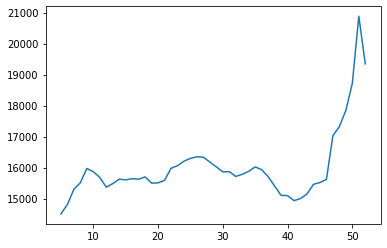

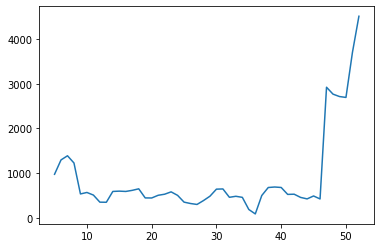

In [ ]:
plt.plot((df['Weekly_Sales'].groupby(df['Week']).mean()).rolling(window=5).mean())
plt.show()
plt.plot((df['Weekly_Sales'].groupby(df['Week']).mean()).rolling(window=5).std())
plt.show()

**Adfuller test for Statioary**

In [ ]:
# adfuller test for stationary
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Weekly_Sales'].groupby(df['Week']).mean(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                 -1.738662
p-value                         0.411311
#Lags Used                     10.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


**According to the the above test and figures, the mean and the SD are not constant across the weeks because of Seasonality, thus it is non stationary time series data.**

##**Preprocessing**

**Remove some features that as no correlation and to remove colinearity**

In [ ]:
df = df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Fuel_Price'], axis=1)

In [ ]:
df

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
Date,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,211.096358,8.106,A,151315,5,2010
2010-02-12,1,1,46039.49,True,38.51,211.242170,8.106,A,151315,6,2010
2010-02-19,1,1,41595.55,False,39.93,211.289143,8.106,A,151315,7,2010
2010-02-26,1,1,19403.54,False,46.63,211.319643,8.106,A,151315,8,2010
2010-03-05,1,1,21827.90,False,46.50,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,45,98,508.37,False,64.88,192.013558,8.684,B,118221,39,2012
2012-10-05,45,98,628.10,False,64.89,192.170412,8.667,B,118221,40,2012
2012-10-12,45,98,1061.02,False,54.47,192.327265,8.667,B,118221,41,2012


In [ ]:
# save to .csv file to have a complete look on the output df so far
df.to_csv('file2.csv')

**After removing features, computing Variance Inflation Factor (VIF) for the degree of Colinearity of each the remaining features**

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#find design matrix for linear regression model using 'rating' as response variable
y, X = dmatrices('Weekly_Sales ~ Store+Dept+IsHoliday+Temperature+CPI+Unemployment+Type+Size+Year+Week', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable
vif

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF,variable
0,0.000000,Intercept
1,1.115144,Store
2,1.000646,Dept
3,1.028972,IsHoliday
4,1.104190,Temperature
5,1.185191,CPI
6,1.233660,Unemployment
7,0.000000,Type
8,1.041981,Size
9,1.074708,Year


**ALL VIF values around 1 which means the independent variables are non-correlated. This is necessary for reliable results in linear regression models.**

**The Preprocessing Pipeline**

In [ ]:
# store columns according to data type
num_columns = df.select_dtypes(include=['number']).columns
object_columns = df.select_dtypes(include=['object']).columns
bolean_columns = df.select_dtypes(include=['bool']).columns

In [ ]:
categorical_feats_list = object_columns.tolist() + bolean_columns.tolist()

In [ ]:
categorical_feats_list

['Type', 'IsHoliday']

In [ ]:
numerical_feats_list = [ele for ele in num_columns.tolist() if ele != 'Weekly_Sales']
numerical_feats_list

['Store', 'Dept', 'Temperature', 'CPI', 'Unemployment', 'Size', 'Week', 'Year']

In [ ]:
# sklearn pipeline
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
cat_transformer = Pipeline([('cat_encoder', OrdinalEncoder(dtype=np.int64, handle_unknown= 'use_encoded_value', unknown_value=3))])
num_transformer = Pipeline([('robust_scalar', RobustScaler())])
# Creating preprocessing pipeline
from sklearn.compose import make_column_transformer
preprocessing = make_column_transformer((cat_transformer, categorical_feats_list),
                                         (num_transformer, numerical_feats_list),
                                         remainder='passthrough')


In [ ]:
X = df.drop(['Weekly_Sales'], axis = 1)
Y = df['Weekly_Sales'].to_numpy()

In [ ]:
# Check the feature matrix after the preprocessing(i.e model input)
preprocess_output = pd.DataFrame(preprocessing.fit_transform(X), columns= preprocessing.transformers_[0][2] +\
                                 preprocessing.transformers_[1][2])
preprocess_output

,Type,IsHoliday,Store,Dept,Temperature,CPI,Unemployment,Size,Week,Year
0,0.0,0.0,-0.954545,-0.642857,-0.716667,0.357955,0.142772,0.102400,-0.875000,-0.5
1,0.0,1.0,-0.954545,-0.642857,-0.854348,0.359769,0.142772,0.102400,-0.833333,-0.5
2,0.0,0.0,-0.954545,-0.642857,-0.802899,0.360353,0.142772,0.102400,-0.791667,-0.5
3,0.0,0.0,-0.954545,-0.642857,-0.560145,0.360733,0.142772,0.102400,-0.750000,-0.5
4,0.0,0.0,-0.954545,-0.642857,-0.564855,0.361112,0.142772,0.102400,-0.708333,-0.5
...,...,...,...,...,...,...,...,...,...,...
421565,1.0,0.0,1.045455,1.089286,0.101087,0.120590,0.486615,-0.201585,0.541667,0.5
421566,1.0,0.0,1.045455,1.089286,0.101449,0.122541,0.476502,-0.201585,0.583333,0.5
421567,1.0,0.0,1.045455,1.089286,-0.276087,0.124492,0.476502,-0.201585,0.625000,0.5
421568,1.0,0.0,1.045455,1.089286,-0.203623,0.124537,0.476502,-0.201585,0.666667,0.5


##**Models**

In [ ]:
features = [feature for feature in df.columns if feature != 'Weekly_Sales']
features

['Store',
 'Dept',
 'IsHoliday',
 'Temperature',
 'CPI',
 'Unemployment',
 'Type',
 'Size',
 'Week',
 'Year']

**Spliting Data into Training and Testing Manually (Method1)**

In [ ]:
# Split Data into training/Validation and Testing Sets Manually - test data are the last 30% samples
test_size = int(len(df)*0.3)
df_train = df[:-test_size]
df_test = df[-test_size:]

In [ ]:
print('training samples size =', len(df_train))
print('testing samples size =', len(df_test))

training samples size = 295099
testing samples size = 126471


In [ ]:
df_train

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
Date,,,,,,,,,,,
2010-02-05,1,1,24924.50,False,42.31,211.096358,8.106,A,151315,5,2010
2010-02-12,1,1,46039.49,True,38.51,211.242170,8.106,A,151315,6,2010
2010-02-19,1,1,41595.55,False,39.93,211.289143,8.106,A,151315,7,2010
2010-02-26,1,1,19403.54,False,46.63,211.319643,8.106,A,151315,8,2010
2010-03-05,1,1,21827.90,False,46.50,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...
2012-01-27,31,10,14262.67,False,50.79,219.718864,7.057,A,203750,4,2012
2012-02-03,31,10,14635.12,False,55.83,219.811885,7.057,A,203750,5,2012
2012-02-10,31,10,18208.24,True,46.52,219.904907,7.057,A,203750,6,2012


In [ ]:
df_test

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
Date,,,,,,,,,,,
2012-03-02,31,10,19204.62,False,59.30,220.486689,7.057,A,203750,9,2012
2012-03-09,31,10,18854.09,False,57.16,220.697433,7.057,A,203750,10,2012
2012-03-16,31,10,20550.49,False,63.39,220.849847,7.057,A,203750,11,2012
2012-03-23,31,10,18896.41,False,62.96,220.924486,7.057,A,203750,12,2012
2012-03-30,31,10,19553.33,False,67.87,220.999125,7.057,A,203750,13,2012
...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,45,98,508.37,False,64.88,192.013558,8.684,B,118221,39,2012
2012-10-05,45,98,628.10,False,64.89,192.170412,8.667,B,118221,40,2012
2012-10-12,45,98,1061.02,False,54.47,192.327265,8.667,B,118221,41,2012


**Spliting Data into training and Testing by TimeSeriesSplit (Method2)**

In [ ]:
# Time-series split
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

In [ ]:
for i, (train_index, valid_index) in enumerate(tscv.split(df_train)):
  print(f"Fold {i}:")
  print(f"  Train: index={train_index}")
  print(f"  Test:  index={valid_index}")

Fold 0:
  Train: index=[    0     1     2 ... 26826 26827 26828]
  Test:  index=[26829 26830 26831 ... 53653 53654 53655]
Fold 1:
  Train: index=[    0     1     2 ... 53653 53654 53655]
  Test:  index=[53656 53657 53658 ... 80480 80481 80482]
Fold 2:
  Train: index=[    0     1     2 ... 80480 80481 80482]
  Test:  index=[ 80483  80484  80485 ... 107307 107308 107309]
Fold 3:
  Train: index=[     0      1      2 ... 107307 107308 107309]
  Test:  index=[107310 107311 107312 ... 134134 134135 134136]
Fold 4:
  Train: index=[     0      1      2 ... 134134 134135 134136]
  Test:  index=[134137 134138 134139 ... 160961 160962 160963]
Fold 5:
  Train: index=[     0      1      2 ... 160961 160962 160963]
  Test:  index=[160964 160965 160966 ... 187788 187789 187790]
Fold 6:
  Train: index=[     0      1      2 ... 187788 187789 187790]
  Test:  index=[187791 187792 187793 ... 214615 214616 214617]
Fold 7:
  Train: index=[     0      1      2 ... 214615 214616 214617]
  Test:  index=[21461

**Spliting Data into Training and Testing by train_test_split (Method3)**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(["Weekly_Sales"], axis=1), df["Weekly_Sales"], test_size=0.3)

In [ ]:
print('training samples size =', len(x_train))
print('testing samples size =', len(x_test))

training samples size = 295099
testing samples size = 126471


In [ ]:
x_train

,Store,Dept,IsHoliday,Temperature,CPI,Unemployment,Type,Size,Week,Year
Date,,,,,,,,,,
2011-08-26,44,74,False,81.53,129.283258,6.560,C,39910,34,2011
2011-02-25,12,38,False,48.45,128.130000,14.021,B,112238,8,2011
2012-01-13,12,56,False,48.07,130.244000,12.187,B,112238,2,2012
2012-08-24,15,87,False,66.98,138.281452,8.193,B,123737,34,2012
2012-05-18,7,2,False,49.41,197.555314,8.090,B,70713,20,2012
...,...,...,...,...,...,...,...,...,...,...
2010-07-02,7,12,False,61.31,189.488260,9.017,B,70713,26,2010
2011-09-16,31,13,False,80.62,215.694438,7.852,A,203750,37,2011
2011-11-04,31,40,False,56.01,217.485361,7.441,A,203750,44,2011


In [ ]:
y_train

Date
2011-08-26      430.28
2011-02-25    46828.37
2012-01-13      111.27
2012-08-24     9292.54
2012-05-18    17224.58
                ...   
2010-07-02     8085.41
2011-09-16    42199.07
2011-11-04    57950.28
2010-02-26    23692.83
2010-07-23     3582.12
Name: Weekly_Sales, Length: 295099, dtype: float64

**Adding Week and Year as features to the features set, and the way data arranged in the dataset, makes Mehtod 2 and 3 fits better for models learning.**

#**Random Forest Calssifer**

**Random Forest I- using TimeSeriesSplit**

In [ ]:
from sklearn.model_selection import GridSearchCV
RF_Reg = RandomForestRegressor()
RF_Reg_pipeline = Pipeline([('transformer', preprocessing), ('estimator',  RF_Reg)])
param_grid = {
    'estimator__n_estimators': [50, 58],
    'estimator__max_depth': [23, 24, 25, 26],
    'estimator__max_features': [7]
}
gssearch = GridSearchCV(RF_Reg_pipeline.fit(df_train[features], df_train["Weekly_Sales"]),param_grid=param_grid,
                        scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
gssearch.fit(df_train[features], df_train['Weekly_Sales'])

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OrdinalEncoder(dtype=<class 'numpy.int64'>,
                                                                                                         handle_unknown='use_encoded_value',
                                                                                                         unknown_value=3))]),
                                                                         ['Type',
                                                                          'IsHoliday']),
                                                                        ('pipeline-2',
           

In [ ]:
gssearch.best_params_

{'estimator__max_depth': 25,
 'estimator__max_features': 7,
 'estimator__n_estimators': 50}

In [ ]:
gssearch.best_score_

-6604.524232448183

In [ ]:
# Reset the index
df_no_index = df_train.reset_index()

In [ ]:
# Run RFC on with Optimised Paramters
wmaes_cv = []
for i, (train_index, valid_index) in enumerate(tscv.split(df_no_index)):
  x_train, y_train = df_no_index.loc[train_index][features], df_no_index.loc[train_index]['Weekly_Sales']
  x_valid, y_valid = df_no_index.loc[valid_index][features], df_no_index.loc[valid_index]['Weekly_Sales']
  RF_Reg = RandomForestRegressor(n_estimators=58, max_depth=25, max_features=7, min_samples_split=3, min_samples_leaf=1)
  RF_Reg_pipeline = Pipeline([('transformer', preprocessing), ('estimator',  RF_Reg)])
  RF_Reg_pipeline.fit(x_train, y_train)
  pred_week_sales = RF_Reg_pipeline.predict(x_valid)
  print("Fold", i, " - WMAE", WMAE(x_valid, y_valid, pred_week_sales))
  wmaes_cv.append(WMAE(x_valid, y_valid, pred_week_sales))
print('WMAE:', np.mean(wmaes_cv))

Fold 0  - WMAE 9857.9152
Fold 1  - WMAE 9247.3096
Fold 2  - WMAE 9616.6848
Fold 3  - WMAE 6642.2143
Fold 4  - WMAE 6690.296
Fold 5  - WMAE 7720.5051
Fold 6  - WMAE 8100.8327
Fold 7  - WMAE 6645.5253
Fold 8  - WMAE 6996.7623
Fold 9  - WMAE 8757.2705
WMAE: 8027.53158


In [ ]:
pred_week_sales_test = RF_Reg_pipeline.predict(df_test[features])
test_WMER = WMAE(df_test, df_test['Weekly_Sales'], pred_week_sales_test)
test_WMER

8967.7121

**RF using Pipeline + k-cross validation - train_test_split Method**

In [ ]:
RF1= RandomForestRegressor(n_estimators=58, max_depth=20, max_features=9, min_samples_split=3, min_samples_leaf=1,
                            random_state=42)
RF1_pipeline = Pipeline([('transformer', preprocessing), ('estimator',  RF1)])
cvfolds = KFold(n_splits=5)
RF1_cv = cross_validate(RF1_pipeline.fit(x_train, y_train), x_train, y_train, \
                            cv = cvfolds, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), return_train_score=True)
RF1_cv

{'fit_time': array([57.48248887, 57.3543725 , 60.48310304, 57.20409179, 57.92692804]),
 'score_time': array([1.33147359, 1.34554696, 1.36874938, 1.33394814, 1.35363317]),
 'test_r2': array([0.97178498, 0.97680838, 0.96728365, 0.97290096, 0.9711729 ]),
 'train_r2': array([0.99315162, 0.99313721, 0.99356637, 0.99327669, 0.99341072]),
 'test_neg_mean_squared_error': array([-14575716.74235044, -12117105.18691584, -16776387.99188077,
        -13835302.58555994, -15450135.52950813]),
 'train_neg_mean_squared_error': array([-3564274.87526212, -3561656.47309572, -3354502.90823886,
        -3509332.5393872 , -3397488.26315423]),
 'test_neg_mean_absolute_error': array([-1542.01848402, -1532.66377893, -1547.10666196, -1522.6976835 ,
        -1552.09294463]),
 'train_neg_mean_absolute_error': array([-840.13002171, -837.41246319, -834.38052898, -840.33347396,
        -834.94952013])}

In [ ]:
RFC_preds= RF1_pipeline.predict(x_test)
test_WMER = WMAE(x_test, y_test, RFC_preds)
test_WMER

1661.9933

In [ ]:
# List samples with Highest error
test_truth_preds= pd.DataFrame()
test_truth_preds["Week"], test_truth_preds["Dept"], test_truth_preds["Size"], test_truth_preds['test_truth'], test_truth_preds['test_pred'], \
test_truth_preds['Diff'], test_truth_preds['abs(Diff)'], test_truth_preds["IsHoliday"] = \
x_test["Week"], x_test["Dept"], x_test["Size"], y_test, RFC_preds, y_test-RFC_preds, abs(y_test-RFC_preds), x_test["IsHoliday"]
test_truth_preds.sort_values(by=['abs(Diff)'], ascending=False).head(50)

,Week,Dept,Size,test_truth,test_pred,Diff,abs(Diff),IsHoliday
Date,,,,,,,,
2011-11-25,47,72,103681,649770.18,270391.268135,379378.911865,379378.911865,True
2010-11-26,47,72,103681,627962.93,288182.179931,339780.750069,339780.750069,True
2011-12-23,51,7,126512,341308.00,161891.429475,179416.570525,179416.570525,False
2011-12-23,51,72,126512,296628.29,124585.317782,172042.972218,172042.972218,False
2011-12-23,51,7,205863,318422.01,186151.895322,132270.114678,132270.114678,False
2010-11-26,47,72,155083,129601.64,255378.296905,-125776.656905,125776.656905,True
2011-11-25,47,72,155083,145504.24,254587.766917,-109083.526917,109083.526917,True
2010-11-26,47,72,151315,196810.42,297393.826397,-100583.406397,100583.406397,True
2011-12-16,50,72,184109,79361.48,178808.034703,-99446.554703,99446.554703,False


**Highest differences between truth and predicted values occur in samples of which weekly sales high -away from the mean (16K)- plus at holiday Weeks. Thus, relatively low MAE isn't indicative for the errors occurs in all samples.**

**Relatively low WMAE comes from the dist. of Weekly Sales is being right-skewd. That means most inputs falls in small sales range at which the model good to estimate.**

**The samples in the above table at Weeks: 13/2010, 16/2011, Week14/2012  are the Easter holiday -so Holiday Weeks- which hadn't got labeled by the dataset. This adds on to the observation that the model fails at holidays - where high sales happed**

In [ ]:
# List samples with least error
test_truth_preds.sort_values(by=['abs(Diff)'], ascending=False).tail(20)

,Week,Dept,Size,test_truth,test_pred,Diff,abs(Diff),IsHoliday
Date,,,,,,,,
2011-04-01,13,45,203819,15.00,15.064841,-0.064841,0.064841,False
2010-07-30,30,54,34875,62.00,61.937672,0.062328,0.062328,False
2011-08-19,33,26,42988,8.50,8.560147,-0.060147,0.060147,False
2012-09-14,37,28,39690,50.75,50.692304,0.057696,0.057696,False
2010-05-21,20,4,202505,32656.66,32656.603313,0.056687,0.056687,False
2011-04-29,17,20,39690,60.50,60.555046,-0.055046,0.055046,False
2010-10-08,40,25,42988,29.50,29.447885,0.052115,0.052115,False
2010-04-09,14,51,57197,17.04,16.993682,0.046318,0.046318,False
2011-12-02,48,7,39910,463.84,463.880650,-0.040650,0.040650,False


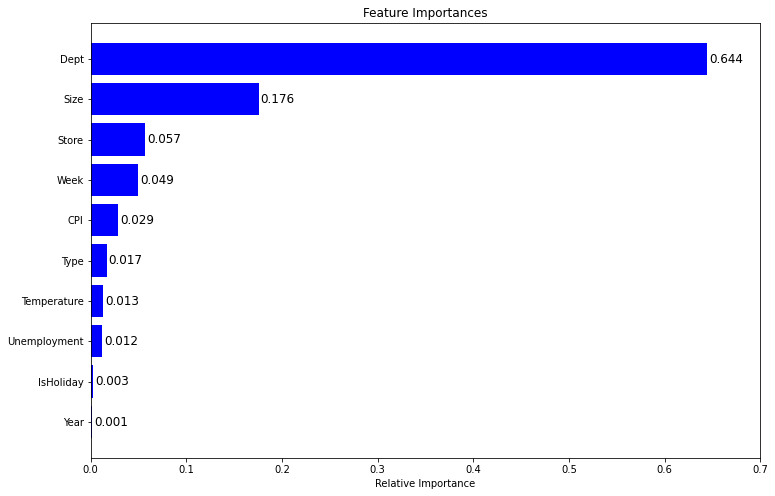

In [ ]:
# Plotting Feature Importance of the RF Regressor
features = preprocess_output.columns
feature_importance_list = RF1_pipeline['estimator'].feature_importances_
indices = np.argsort(feature_importance_list)
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance_list[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.xlim(0, 0.7)
# add the annotations
for y, x in zip(feature_importance_list[indices], np.arange(len(features))):
    plt.annotate('{:.3f}'.format(y), xy=(y+0.02, x), ha='center', va='center', size=12)
plt.show()

**Make adjustment in the data for capturing Easter Holiday**

In [ ]:
df_copy = df.copy()
df_copy.loc[(df_copy.Year==2010) & (df_copy.Week==13), 'IsHoliday'] = True
df_copy.loc[(df_copy.Year==2011) & (df_copy.Week==16), 'IsHoliday'] = True
df_copy.loc[(df_copy.Year==2012) & (df_copy.Week==14), 'IsHoliday'] = True

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_copy.drop(["Weekly_Sales"], axis=1), df_copy["Weekly_Sales"], test_size=0.3)

In [ ]:
RF2= RandomForestRegressor(n_estimators=58, max_depth=20, max_features=9, min_samples_split=3, min_samples_leaf=1,
                            random_state=42)
RF2_pipeline = Pipeline([('transformer', preprocessing), ('estimator',  RF2)])
cvfolds = KFold(n_splits=5)
RF2_cv = cross_validate(RF2_pipeline.fit(x_train, y_train), x_train, y_train, \
                            cv = cvfolds, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'), return_train_score=True)
RF2_cv

{'fit_time': array([61.73112822, 60.29639697, 60.3683691 , 61.20414042, 61.28952146]),
 'score_time': array([1.42980194, 1.39577293, 1.44713473, 1.42198443, 1.50713563]),
 'test_r2': array([0.97313757, 0.97065322, 0.97619758, 0.9716505 , 0.97568412]),
 'train_r2': array([0.99365429, 0.99365626, 0.99376558, 0.99406998, 0.99361576]),
 'test_neg_mean_squared_error': array([-14271275.05945991, -15339198.42806198, -12362156.74215567,
        -14442779.95543797, -12435260.76691856]),
 'train_neg_mean_squared_error': array([-3272661.07789687, -3285300.73027131, -3233864.23761537,
        -3090664.16854586, -3324284.0167486 ]),
 'test_neg_mean_absolute_error': array([-1542.63054841, -1531.93632459, -1520.7418005 , -1520.20927353,
        -1518.19840234]),
 'train_neg_mean_absolute_error': array([-832.42973694, -832.20839955, -832.6685793 , -825.98520117,
        -831.65843951])}

In [ ]:
RF2_preds= RF2_pipeline.predict(x_test)
test_WMER = WMAE(x_test, y_test, RF2_preds)
test_WMER

1655.4805

In [ ]:
test_truth_preds= pd.DataFrame()
test_truth_preds["Week"], test_truth_preds["Dept"], test_truth_preds["Size"], test_truth_preds['test_truth'], test_truth_preds['test_pred'], \
test_truth_preds['Diff'], test_truth_preds['abs(Diff)'], test_truth_preds["IsHoliday"] = \
x_test["Week"], x_test["Dept"], x_test["Size"], y_test, RF2_preds, y_test-RF2_preds, abs(y_test-RF2_preds), x_test["IsHoliday"]
test_truth_preds.sort_values(by=['abs(Diff)'], ascending=False).head(50)

,Week,Dept,Size,test_truth,test_pred,Diff,abs(Diff),IsHoliday
Date,,,,,,,,
2010-11-26,47,72,126512,693099.36,389131.868911,303967.491089,303967.491089,True
2010-12-24,51,72,126512,404245.03,195562.035402,208682.994598,208682.994598,False
2011-12-23,51,72,126512,296628.29,138970.984664,157657.305336,157657.305336,False
2010-11-26,47,72,200898,474330.10,324601.258908,149728.841092,149728.841092,True
2011-12-23,51,7,126512,341308.00,208387.588418,132920.411582,132920.411582,False
2010-11-26,47,72,203742,422306.25,304015.743348,118290.506652,118290.506652,True
2010-12-24,51,72,205863,299060.25,204183.659118,94876.590882,94876.590882,False
2011-11-25,47,72,203742,392023.02,304330.684586,87692.335414,87692.335414,True
2010-07-09,27,11,114533,136882.72,52184.462818,84698.257182,84698.257182,False


**After the adjustment, Week 13/2010 and Week16/2011 are not shown among the highest error prediction. Also for Week 14/2012, the diff. between Truth and Pred. want down from 96276 to 51187.**

**Random Forest I - Split Data Manually (30% of data at from the tail as test set)**

In [ ]:
RF_Reg_2 = RandomForestRegressor(n_estimators=60,max_depth=9,max_features=3,
                                 min_samples_split=3, min_samples_leaf=1,
                                 random_state=42)
RF_Reg_2.fit(df_train[features], df_train['Weekly_Sales'])

RandomForestRegressor(max_depth=9, max_features=3, min_samples_split=3,
                      n_estimators=60, random_state=42)

In [ ]:
pred_train_df_train_2 = RF_Reg_2.predict(df_train[features])
train_WMER = WMAE(df_train, df_train['Weekly_Sales'], pred_train_df_train_2)
train_WMER

9971.4069

In [ ]:
pred_week_sales_test_2 = RF_Reg_2.predict(df_test[features])
test_WMER = WMAE(df_test, df_test['Weekly_Sales'], pred_week_sales_test_2)
test_WMER

10212.9079

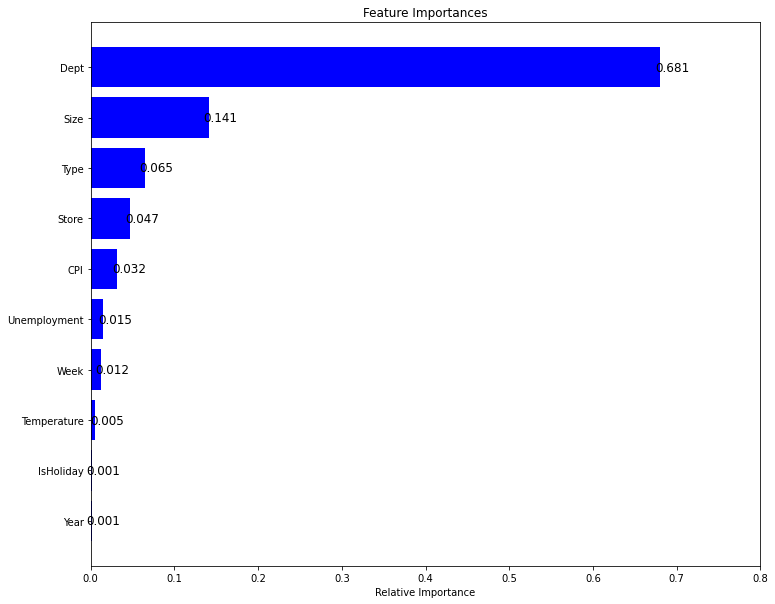

In [ ]:
feature_importance_list = RF_Reg_2.feature_importances_
indices = np.argsort(feature_importance_list)
plt.figure(figsize=(12, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance_list[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.xlim(0, 0.8)
# add the annotations
for y, x in zip(feature_importance_list[indices], np.arange(len(features))):
    plt.annotate('{:.3f}'.format(y), xy=(y+0.014, x), ha='center', va='center', size=12)
plt.show()

#**ARIMA/SARIMA models**

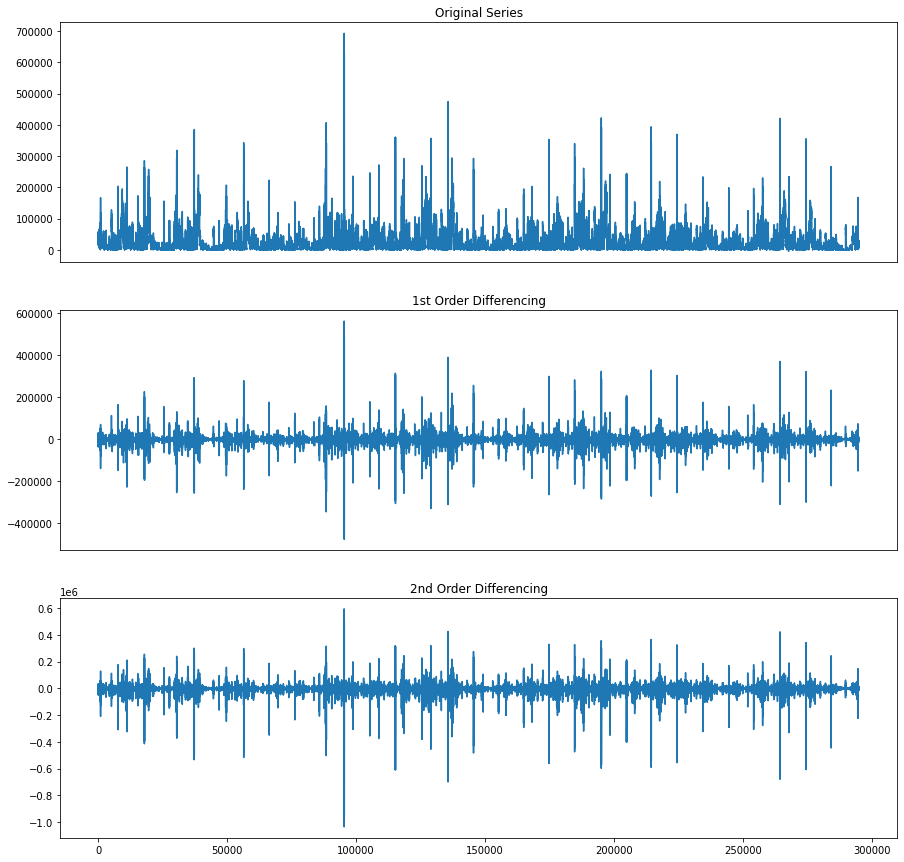

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15, 15))
ax1.plot(df.Weekly_Sales); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df.Weekly_Sales.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df.Weekly_Sales.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

**Check Stationary test after applying 1st diff. transformation**

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Weekly_Sales'].diff().groupby(df['Week']).mean(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                 -2.906978
p-value                         0.044543
#Lags Used                      3.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


**p-value less than 5%, the difference of time series is stationary ( or almost since t-satistic value is little higher than that of 5% critical value)**

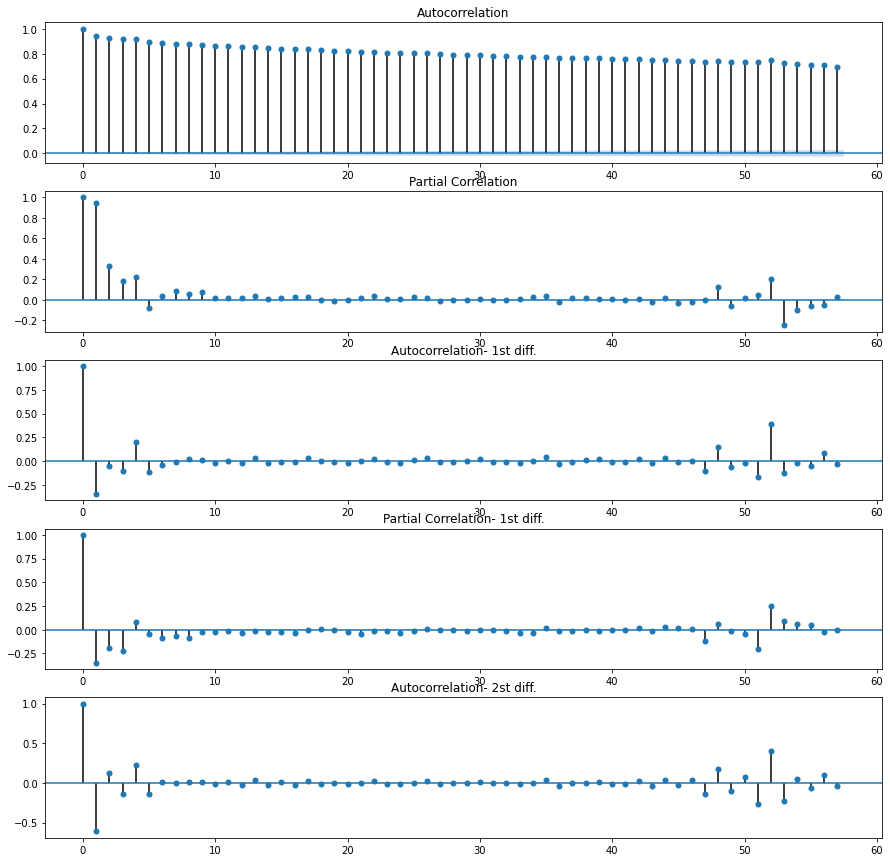

In [ ]:
# Plot Autocorrelation (ACF) and Partial AutoCorrelation(PACF) for choosing p, d,q parameter of ARIMA - for
# the total Weekly_Sales regardless the granularity of Stores and Depts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(15,15))
# ACF and PACF for Raw data
plot_acf(df.Weekly_Sales, ax=ax1, alpha=0.05)
plot_pacf(df.Weekly_Sales, ax=ax2, alpha=0.05, title='Partial Correlation')
# ACF for the 1st difference
plot_acf(df.Weekly_Sales.diff()[1:], ax=ax3, alpha=0.05, title='Autocorrelation- 1st diff.')
# PACF for 1st
plot_pacf(df.Weekly_Sales.diff()[1:], ax=ax4, alpha=0.05, title='Partial Correlation- 1st diff.')
# ACF for the 2nd difference
plot_acf(df.Weekly_Sales.diff().diff()[2:], ax=ax5, alpha=0.05, title='Autocorrelation- 2st diff.')
plt.show()

**The Weekly Sales series values are highly correlated (subplot 1). Linear Models like ARIMA requires inputs to be independent (not highly correlated) to get reliable predictions. Also, ACF does not tail off for many lags. Thus, the first and second difference plotted to select q, d parameters of ARIMA. For this case , going with d=1 since it makes the Series stationay. 2nd difference has little impact and seems has no added benifit.**

**Taking first and second difference does not eliminate Sales spikes in Holiday-Weeks like in Week 47 and 51 as shown in 1st and 2nd difference above. This would help to detrend the time-series but isn't helpful in removing seasonal patterns**

**Based on Partial Autocorrelation plot above, p=9/10 as being first lag doesn't cross the significant level (or at least not far)**

**The ACF and PACF plot shows seasonality at Weeks 47-52 every 52-sampel cycle when taking the difference of 1st order.**

**ARIMA Model: Predicting Weekly Sales based on past values of Weekly Sales only (No exogenous variables)**

**ARIMA (Statsmodels module)**

In [ ]:
# ARIMA Model
ARIMA111 = ARIMA(df_train.Weekly_Sales, order=(1,1,1))
ARIMA111_fit = ARIMA111.fit()
print(ARIMA111_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g.

                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:               295099
Model:                 ARIMA(1, 1, 1)   Log Likelihood            -3042619.587
Date:                Sat, 18 Feb 2023   AIC                        6085245.173
Time:                        10:23:54   BIC                        6085276.958
Sample:                             0   HQIC                       6085254.373
                             - 295099                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2375      0.001    431.263      0.000       0.236       0.239
ma.L1         -0.6875      0.000  -1422.285      0.000      -0.688      -0.687
sigma2      5.256e+07   1.36e-11   3.88e+18      0.0

In [ ]:
train_preds = ARIMA111_fit.predict()
# WMAE of df_tain
WMAE(df_train,df_train.Weekly_Sales, train_preds)

3108.2684

In [ ]:
dftest_forecast = pd.DataFrame(ARIMA111_fit.forecast(steps=len(df_test), alpha=0.05))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [ ]:
index = df_test.index.date
dftest_forecast["Date"] = index
dftest_forecast= dftest_forecast.set_index("Date").squeeze()

In [ ]:
# WMAE of testing data
WMAE(df_test,df_test.Weekly_Sales, dftest_forecast)

15344.8979

**ARIMA model with p=1, d=1, q=1 unable to fit unseen sampels as good as train time-series plus the WMAE for training is pretty high.**

**Remove Seasonality by subtract sample-52 each from each sample**

In [ ]:
# difference function to remove seasonality
def difference(dataset):
 diff52 = list()
 S = 52   # repeating period
 for i in range(S, len(dataset)):
  value = dataset[i] - dataset[i - S]
  diff52.append(value)
 return diff52

In [ ]:
diff = pd.Series(difference(df.Weekly_Sales))
diff

0        -3258.74
1        -8152.32
2         5250.32
3          -39.71
4        -1500.29
           ...   
421513    -218.68
421514    -266.88
421515      64.62
421516    -298.83
421517     -91.10
Length: 421518, dtype: float64

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                    -69.792990
p-value                             0.000000
#Lags Used                         97.000000
Number of Observations Used    421420.000000
Critical Value (1%)                -3.430366
Critical Value (5%)                -2.861547
Critical Value (10%)               -2.566774
dtype: float64


**Seems that taking Seasonal difference makes the TS to be Stationary**

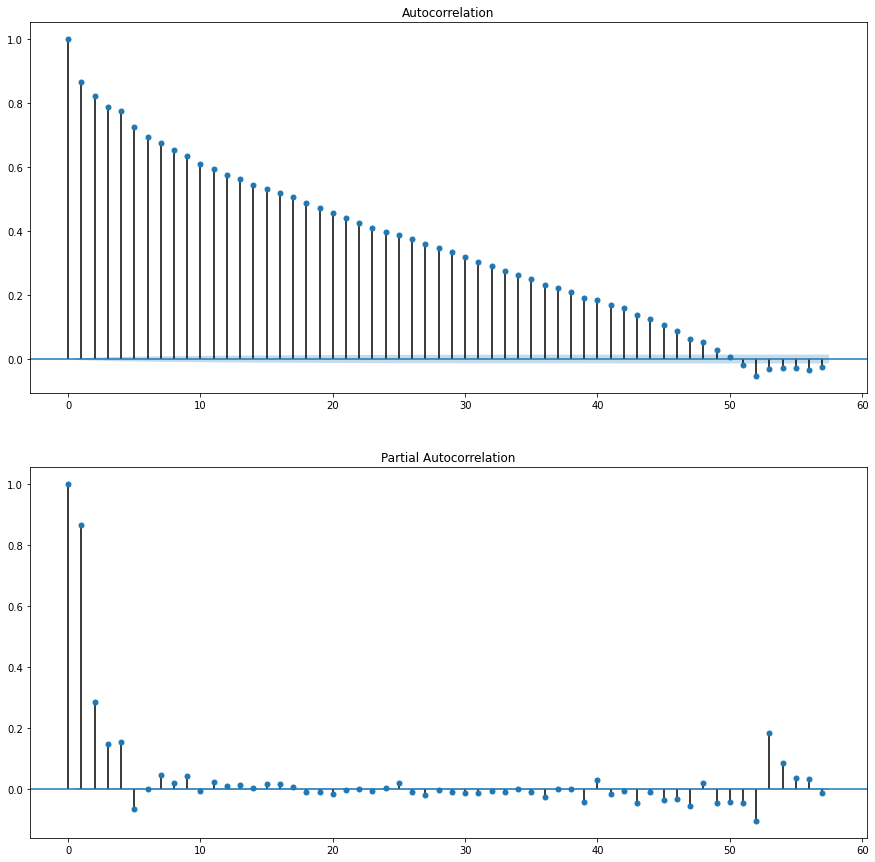

In [ ]:
# Plot ACF and PACF after removing Seasonality (52nd differnce series)
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15))
plot_acf(diff, ax=ax1, alpha=0.05)
plot_pacf(diff, ax=ax2, alpha=0.05)
#plot_acf(diff[1:], ax=ax2, alpha=0.05, title='Autocorrelation- 1st diff.')
plt.show()

**ARIMA for Store 35 Dept. 95**

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


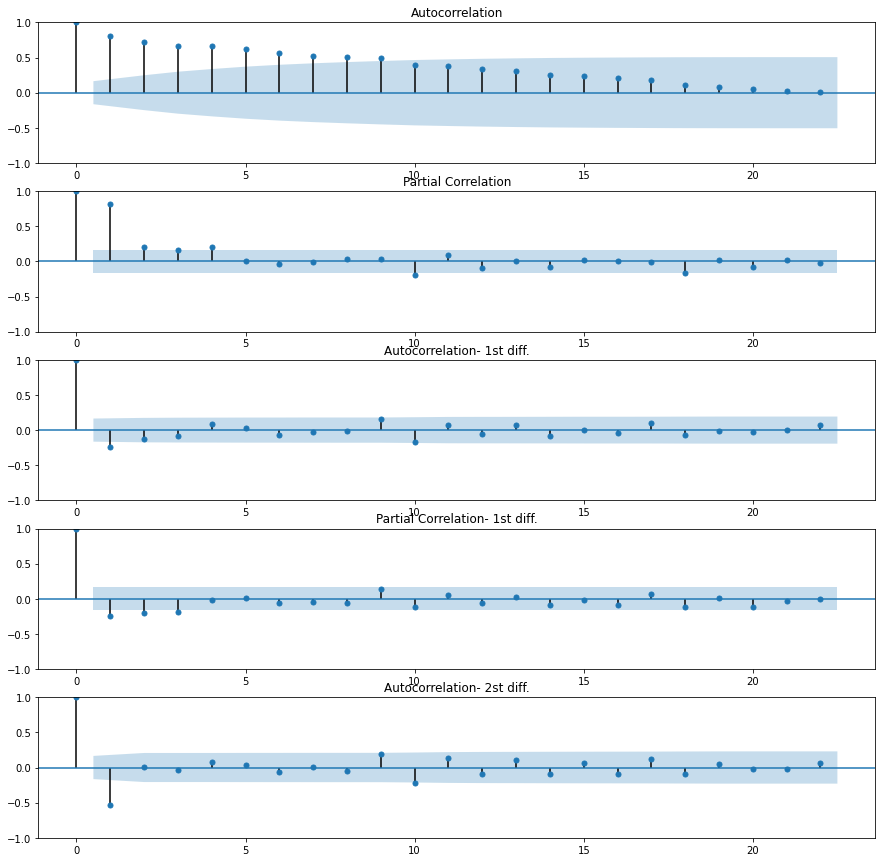

In [ ]:
weekly_sales_store35_dept95 = df.loc[(df.Store==35) & (df.Dept==95)]["Weekly_Sales"]
# Plot Autocorrelation (ACF) and Partial AutoCorrelation(PACF) for choosing p, d,q, Q, D, Q, S parameters of SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(15,15))
# ACF and PACF for Raw data
plot_acf(weekly_sales_store35_dept95, ax=ax1, alpha=0.05)
plot_pacf(weekly_sales_store35_dept95, ax=ax2, alpha=0.05, title='Partial Correlation')
# ACF for the 1st difference
plot_acf(weekly_sales_store35_dept95.diff()[1:], ax=ax3, alpha=0.05, title='Autocorrelation- 1st diff.')
# PACF for 1st
plot_pacf(weekly_sales_store35_dept95.diff()[1:], ax=ax4, alpha=0.05, title='Partial Correlation- 1st diff.')
# ACF for the 2nd difference
plot_acf(weekly_sales_store35_dept95.diff().diff()[2:], ax=ax5, alpha=0.05, title='Autocorrelation- 2st diff.')
plt.show()

In [ ]:
# Stationary Test
dftest = adfuller(weekly_sales_store35_dept95, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Test Statistic                  -1.982169
p-value                          0.294446
#Lags Used                       3.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64


In [ ]:
#AutoArima Function
def AutoArima_Model(store, dept, plot_diagnostics=False):
  store_dept_samples = df.loc[(df.Store==store) & (df.Dept==dept)]

  #train - test split (30% for testing)
  test_size = int(len(store_dept_samples)*0.3)
  autoarima_train = store_dept_samples[:-test_size]
  autoarima_test = store_dept_samples[-test_size:]

  #pre-processing
  autoarima_train_feat_trans = preprocessing.fit_transform(autoarima_train[features])
  autoarima_test_feat_trans = preprocessing.transform(autoarima_test[features])


  # Set-Up the Model
  AutoArima = arima.auto_arima(autoarima_train["Weekly_Sales"], start_p=1, d=None, start_q=1,
                            max_p=4, max_d=1, max_q=4, start_P=1, D=None, start_Q=1, max_P=4, max_D=1, max_Q=2,
                            max_order=3, m=52, seasonal=True, stationary=False, alpha=0.05, stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=10,
                            suppress_warnings=True, error_action='trace', trace=False, random=False,
                            random_state=True, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mae', scoring_args=None,
                            with_intercept='auto', sarimax_kwargs=None)



#pipeline = Pipeline([('transformer', preprocessing), ('estimator', AutoArima)])
#AutoArima_model = TransformedTargetRegressor(regressor=pipeline, transformer=PowerTransformer())
#AutoArima_model.fit(autoarima_train[features], autoarima_train["Weekly_Sales"])

  # WMAE of testing data
  wmae = WMAE(autoarima_test,autoarima_test.Weekly_Sales,  AutoArima.predict(len(autoarima_test), X=autoarima_test_feat_trans))

  if plot_diagnostics:
    print(AutoArima.summary())
    AutoArima.plot_diagnostics(figsize=(20,10))
    plt.show()

  return wmae

**Looking at Store 35 Dept. 95**

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  101
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -482.419
Date:                             Mon, 20 Feb 2023   AIC                            970.838
Time:                                     22:36:32   BIC                            976.452
Sample:                                 02-05-2010   HQIC                           972.960
                                      - 01-06-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6062      0.468     -1.296      0.195      -1.523       0.311
ar.S.L52      -0.9310      

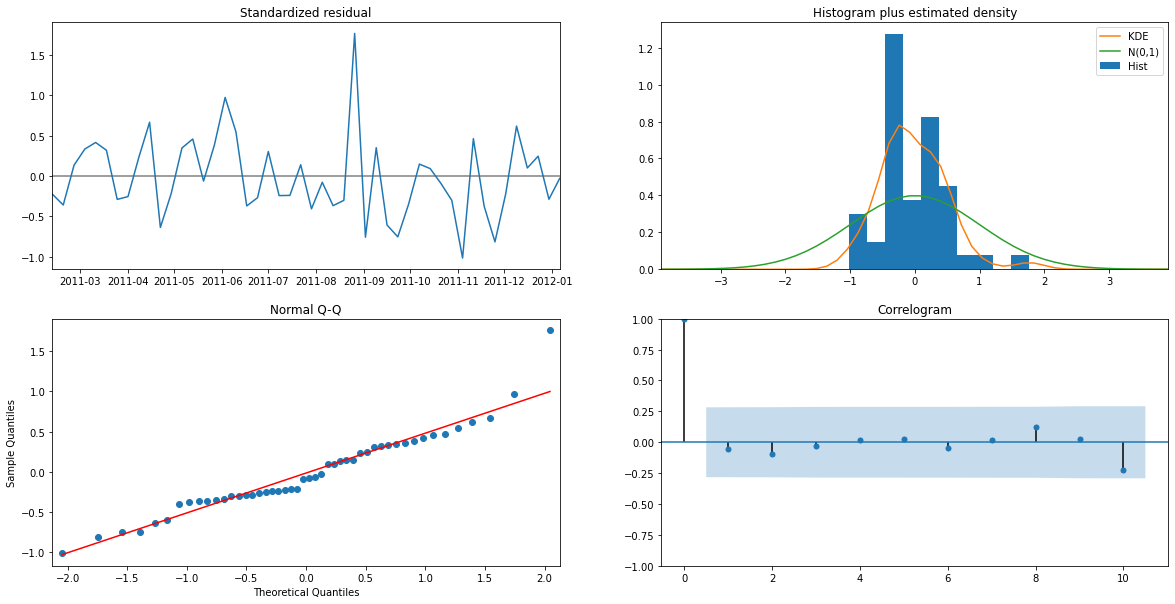

35568.9776

In [ ]:
AutoArima_Model_35_95_loss = AutoArima_Model(35, 95, True)
AutoArima_Model_35_95_loss

**Looking at Store 35 Dept. 95**

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  101
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -479.821
Date:                            Mon, 20 Feb 2023   AIC                            965.642
Time:                                    13:34:33   BIC                            971.318
Sample:                                02-05-2010   HQIC                           967.796
                                     - 01-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -769.8366    577.453     -1.333      0.182   -1901.623     361.950
ar.L1          0.5990      0.067   

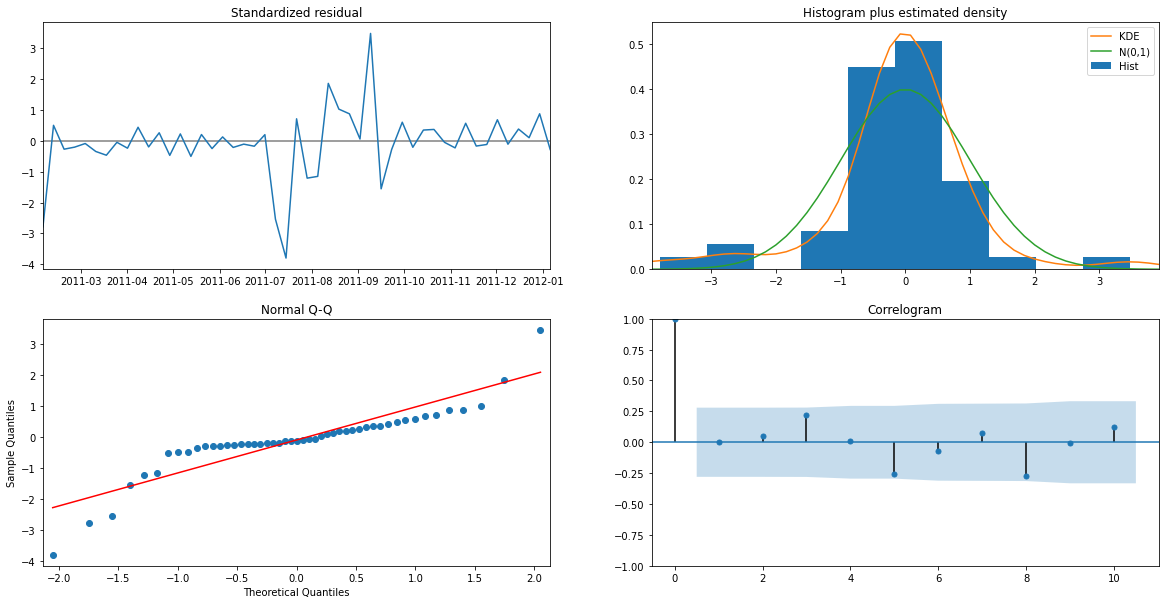

3140.4088

In [ ]:
AutoArima_Model_35_3_loss = AutoArima_Model(35, 3, True)
AutoArima_Model_35_3_loss

**Results over All the Depts. of a store 35**

In [ ]:
WMAE_list=[]
for name, values in df[df.Store == 35][['Dept']].iteritems():
  depts_nums = iter(list(set(values.tolist())))
  print(depts_nums)
  for val in depts_nums:
    if int(val) == 18: #to skip 18
      print("Skip Dept. 18")
      next(depts_nums)
    else:
      wmae = AutoArima_Model(35, int(val), False)
      print("Dept: ", int(val), '= ', wmae)
      WMAE_list.append(wmae)

print('WMAE Avg. = ', WMAE_list/len(WMAE_list))

Dept:  1 =  4053.9366
Dept:  2 =  8485.841
Dept:  3 =  8420.3929
Dept:  4 =  2602.5198
Dept:  5 =  7407.3201
Dept:  6 =  1364.3745
Dept:  7 =  4418.3926
Dept:  8 =  2842.5274
Dept:  9 =  3514.2945
Dept:  10 =  1701.212
Dept:  11 =  6801.0306
Dept:  12 =  616.4724
Dept:  13 =  5909.9136
Dept:  14 =  2842.8453
Dept:  16 =  2920.3575
Dept:  17 =  1552.1836
Skip Dept. 18
Dept:  20 =  955.0647
Dept:  21 =  547.7909
Dept:  22 =  2347.6363
Dept:  23 =  5047.0742
Dept:  24 =  1893.476
Dept:  25 =  3115.6728
Dept:  26 =  2864.2941
Dept:  27 =  214.2873
Dept:  28 =  160.2667
Dept:  29 =  626.0911
Dept:  30 =  960.068
Dept:  31 =  1221.1665
Dept:  32 =  1335.1134
Dept:  33 =  1636.5606
Dept:  34 =  7099.7562
Dept:  35 =  339.8539
Dept:  36 =  1550.1812
Dept:  38 =  4313.7203
Dept:  40 =  2336.8765
Dept:  41 =  1239.8862
Dept:  42 =  1124.5839
Dept:  44 =  278.0746


ValueError: ignored

**Deseason time series with polyfit function**

Coefficients: [ 1.04573475e-42 -2.46917457e-36  2.12117548e-30 -9.26645146e-25
  2.30086814e-19 -3.33752681e-14  2.74199847e-09 -1.14826385e-04
  1.86733289e+00  1.37281274e+04]
295099
295099


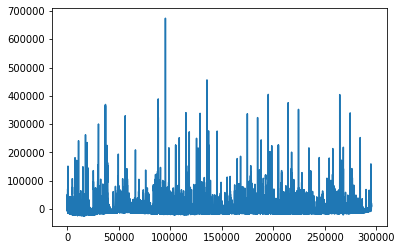

In [ ]:
from numpy import polyfit
# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%len(df_train) for i in range(0, len(df_train))]
y = df_train["Weekly_Sales"].values
degree = 9
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
 value = coef[-1]
 for d in range(degree):
  value += X[i]**(degree-d) * coef[d]
 curve.append(value)
print(len(y))
print(len(curve))
# create seasonally adjusted
values = y
diff = list()
for i in range(len(values)):
 value = values[i] - curve[i]
 diff.append(value)
plt.plot(diff)
plt.show()

In [ ]:
# Arima Impelemtation
ARIMA_diff = ARIMA(diff, order=(10,1,2))
ARIMA_diff_fit = ARIMA_diff.fit()
print(ARIMA_diff_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               295099
Model:                ARIMA(10, 1, 2)   Log Likelihood            -3035106.637
Date:                Wed, 18 Jan 2023   AIC                        6070239.274
Time:                        11:12:34   BIC                        6070377.010
Sample:                             0   HQIC                       6070279.140
                             - 295099                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2037      0.037     -5.480      0.000      -0.277      -0.131
ar.L2          0.4699      0.019     25.183      0.000       0.433       0.506
ar.L3          0.1193      0.005     23.276      0.0

In [ ]:
WMAE(df_test,df_test.Weekly_Sales, ARIMA_diff_fit.forecast(steps=len(df_test), alpha=0.05))

12590.8541

**Univariant Supervised Learning RF Regressor**

In [ ]:
from sklearn.metrics import mean_absolute_error
def walk_forward_validation(data, n_test):
 predictions = list()
 # split dataset
 train, test = train_test_split(data, test_size=n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
  # split test row into input and output columns
  testX, testy = test[i, :-1], test[i, -1]
  # fit model on history and make a prediction
  yhat = random_forest_forecast(history, testX)
  # store forecast in list of predictions
  predictions.append(yhat)
  # add actual observation to history for the next loop
  history.append(test[i])
  # summarize progress
  print(testy, type(testy))
  print(yhat, type(yhat))
  print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 error = mean_absolute_error(test[:, -1], predictions)
 return error, test[:, 1], predictions

In [ ]:
from pandas import concat
from pandas import DataFrame

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
  cols.append(df.shift(i))
# forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
  cols.append(df.shift(-i))
 # put it all together
 agg = concat(cols, axis=1)
 # drop rows with NaN values
 if dropnan:
  agg.dropna(inplace=True)
  print(agg)
 return agg.values

In [ ]:
def random_forest_forecast(train, testX):
 # transform list into array
 train = np.array(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = RandomForestRegressor(n_estimators=100)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 print(1)
 return yhat

               0         0         0
2       24924.50  46039.49  41595.55
3       46039.49  41595.55  19403.54
4       41595.55  19403.54  21827.90
5       19403.54  21827.90  21043.39
6       21827.90  21043.39  22136.64
...          ...       ...       ...
421565    605.96    467.30    508.37
421566    467.30    508.37    628.10
421567    508.37    628.10   1061.02
421568    628.10   1061.02    760.01
421569   1061.02    760.01   1076.80

[421568 rows x 3 columns]
1
7343.65 <class 'numpy.float64'>
[7059.1604] <class 'numpy.ndarray'>
>expected=7343.6, predicted=7059.2
1
4473.12 <class 'numpy.float64'>
[5206.4436] <class 'numpy.ndarray'>
>expected=4473.1, predicted=5206.4
1
29630.45 <class 'numpy.float64'>
[29087.1549] <class 'numpy.ndarray'>
>expected=29630.5, predicted=29087.2
1
38764.04 <class 'numpy.float64'>
[46393.0853] <class 'numpy.ndarray'>
>expected=38764.0, predicted=46393.1
1
2196.03 <class 'numpy.float64'>
[2468.0246] <class 'numpy.ndarray'>
>expected=2196.0, predicted=246

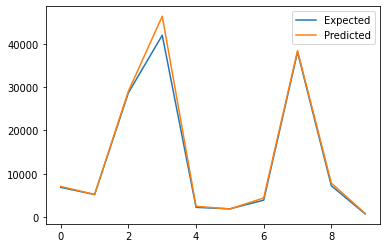

In [ ]:
values = df["Weekly_Sales"].values
values = values.reshape(-1,1)
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=2)
# evaluate
mae, y, yhat = walk_forward_validation(data, 10)
print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()